In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.VariableEncoder.datasets.dataset import CustomDataset
from models.VariableEncoder.training.configs import TrainingConfig
from models.VariableEncoder.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    tgt_time_len = 1 * config.tgt_time_len
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    weather = WeatherDataset(config.train_offset, device=device)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    source, label, mean_std = weather.load(config.air_variable, config.surface_variable, config.only_input_variable, config.constant_variable)
    dataset = CustomDataset(source, label, tgt_time_len, n_only_input=len(config.only_input_variable)+len(config.constant_variable))
    src_var_list = weather.get_var_code(config.air_variable, config.surface_variable + config.only_input_variable+config.constant_variable)
    tgt_var_list = weather.get_var_code(config.air_variable, config.surface_variable)
    return dataset, mean_std, (src_var_list, tgt_var_list)

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, _, _ = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                       (time: 87673, latitude: 30, longitude: 30,
                                   level: 37)
Coordinates:
  * latitude                      (latitude) float32 32.0 32.25 ... 39.0 39.25
  * level                         (level) int64 1 2 3 5 7 ... 925 950 975 1000
  * longitude                     (longitude) float32 124.0 124.2 ... 131.2
  * time                          (time) datetime64[ns] 2011-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    10m_v_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    2m_temperature                (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    geopotential                  (time, level, latitude, longitude) float32 dask.array<chunksize=(1

100%|██████████| 13/13 [00:53<00:00,  4.14s/it]


torch.Size([2, 1, 900])
65.52681 sec
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                       (time: 87673, latitude: 20, longitude: 20,
                                   level: 37)
Coordinates:
  * latitude                      (latitude) float64 21.0 22.5 ... 48.0 49.5
  * level                         (level) int64 1 2 3 5 7 ... 925 950 975 1000
  * longitude                     (longitude) float64 115.5 117.0 ... 144.0
  * time                          (time) datetime64[ns] 2011-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    10m_v_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    2m_temperature                (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    geopotential                  (time, level, latitude, longitude) float32 das

100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


torch.Size([2, 1, 400])
36.04512 sec


In [2]:
%load_ext autoreload
%autoreload 2

from models.VariableEncoder.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/VariableEncoder/tb_logs/lightning_logs/yebfhl4r/checkpoints/epoch=5-step=26298.ckpt')

/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [3]:
from torch.utils.data import DataLoader, Dataset
import tqdm

device = ("cuda" if torch.cuda.is_available() else "cpu" )
device = torch.device(device)

class EncoderDataset(Dataset):
        def __init__(self, data_array: torch.Tensor):
            self.data_array = data_array
        def __len__(self):
            return len(self.data_array)
        def __getitem__(self, idx):
            sample = self.data_array[idx]
            return sample

encoder_dataset = EncoderDataset(dataset.source_dataset)
data_loader = DataLoader(encoder_dataset, batch_size=512, shuffle=False, num_workers=1)
att_maps = []
for i, batch in enumerate(tqdm.tqdm(data_loader)):
    att_map = model.model.get_attention_maps(batch.to(device)).cpu().detach()
    att_maps.append(att_map)

  0%|          | 0/172 [00:00<?, ?it/s]

100%|██████████| 172/172 [05:25<00:00,  1.89s/it]


In [4]:
att_maps = torch.cat(att_maps, dim=1)


In [5]:
print(att_maps.shape)

torch.Size([6, 87673, 231, 231])


In [6]:
att_map = att_map.mean(dim=1)

In [8]:
print(att_map.shape)

torch.Size([6, 231, 231])


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize(att_map: torch.Tensor, title, ind, n_layer):
    sns.heatmap(att_map[n_layer, ind, :].cpu().detach().numpy(), cmap='viridis')
    plt.title(title)
    plt.show()

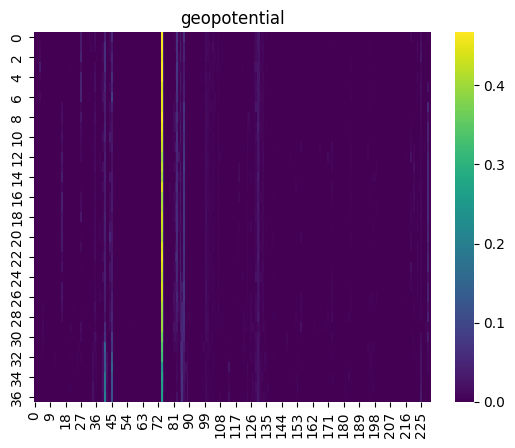

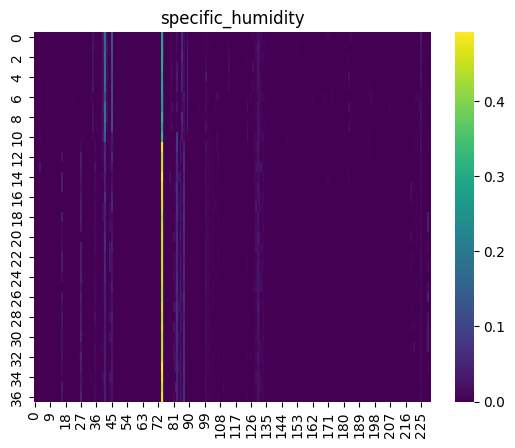

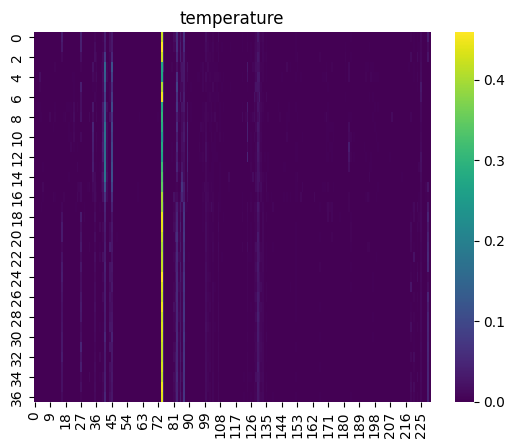

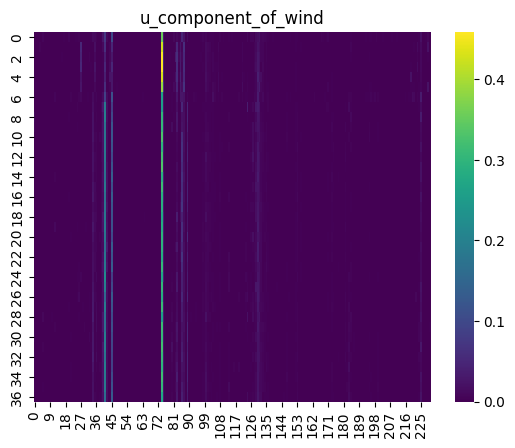

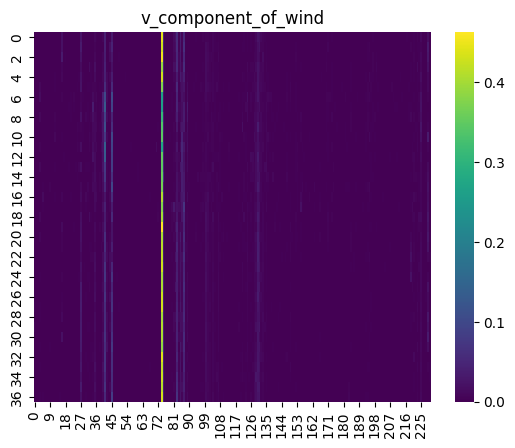

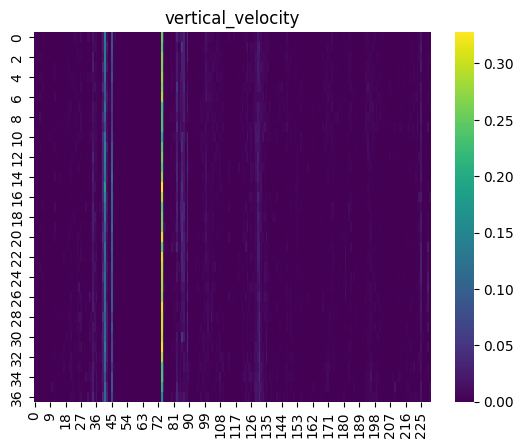

In [13]:
for var in config.training.air_variable:
    idx = WeatherDataset.AIR_VARIABLE.index(var) + 1
    air_list = [ ((idx-1)*37) + i for i in range(37)]
    visualize(att_map, var, air_list, 0)

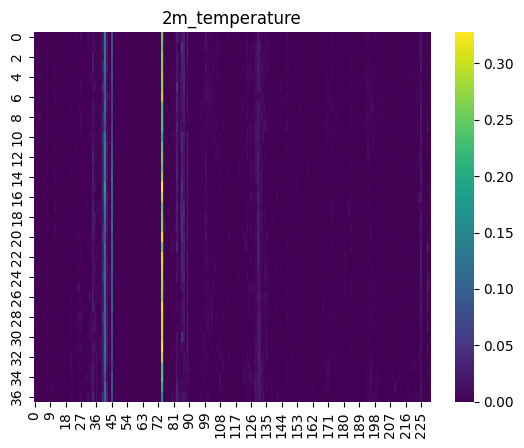

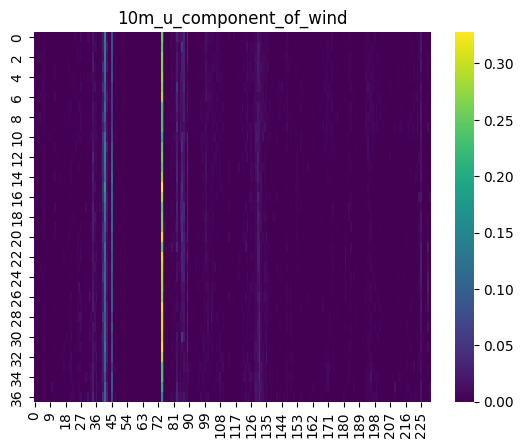

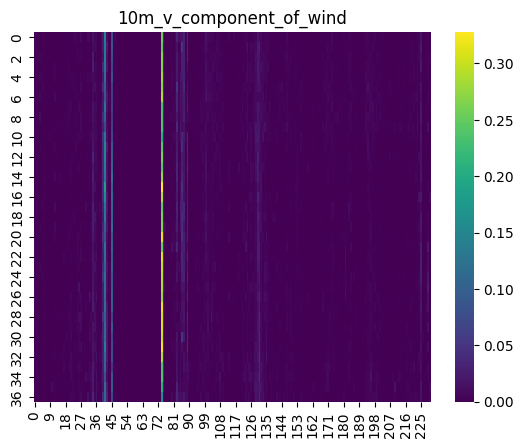

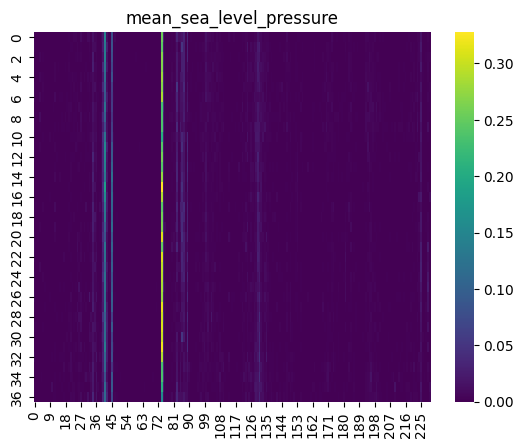

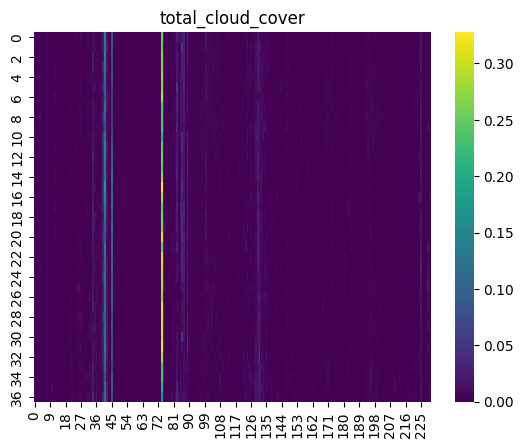

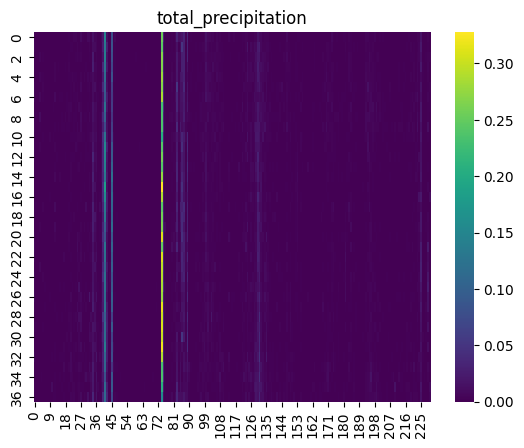

In [14]:
for var in config.training.surface_variable:
    idx = len(WeatherDataset.AIR_VARIABLE) * 37 + WeatherDataset.SURFACE_VARIABLE.index(var)
    visualize(att_map, var, air_list, 0)